In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gamma
import scipy.integrate
import pandas
# TO DO: Update to most recent Planck results
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import winsound

In [2]:
# Path to tables of cosmic variance values
path = "../../CV_Vals/"
file='extrapolate'
save=1
# Get young, blue galaxy spectrum
data = np.loadtxt("../erb2010_continuum.dat")
x = data[:,0]
y = data[:,1] * x**2 / 3.e18 # Convert to correct flux values

# Constants
tot_sky = 41253. # Total degrees on the sky
masses = np.array([7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0]) # Mass bins in log(M/Msun)

# TO DO: Modify cosmic variance values from the tables such that masses <= 8 use the same cosmic variance values as 8.5
# Currently the CV values are incorrectly extrapolated to lower masses from a mass of 8.5
# The code used to calculated the CV values is called "getcv" and is included with the CV value files
#Done

trials = 10000 # Number of trials for calculating median from gamma function
mmin = 9 # Minimum halo mass for HMF
mmax = 13.5 # Maximum halo mass for HMF

In [3]:
# Function to find closest wavelength in measured galaxy spectrum compared to given value
def nearest_wavelength(x, val):
    i = (np.abs(x - val)).argmin()
    return x[i]

In [4]:
# Define a class for different survey designs
class survey:
    def __init__(self, ABmax, area, cv_file, wavelength = 0, num_pointings = 1):
        self.ABmax = ABmax # Limiting AB magnitude of the survey
        self.area = area # Survey area
        self.file = cv_file # Name of cosmic variance table file
        self.point = num_pointings # Number of independent pointings
        self.wavelength = wavelength # Center wavelength for the chosen filter

In [5]:
# Method to take one trial of a gamma distribution with a given variance and mean
def trial(sig_v, mean, trials=10000):
    var = sig_v**2*mean**2
    k = mean**2/var
    t = var/mean
    rand = np.rint(np.random.gamma(k, scale=t, size=trials))
    return rand

In [6]:
val=[-0.04418885, -0.95909967]
def lin(x,a=val[0],b=val[1]):
    return a*x+b

In [7]:
dfz = pandas.read_csv(path+"cv_mashian.csv")
z_vals=dfz["z"]
z_vals = z_vals[::-1]

In [8]:
# Find mean, median number of galaxies found for a given survey design
def mean_median(survey, correction = True, random=True):
    # Get survey information
    point = survey.point
    survey_area = survey.area * point
    ABmax = survey.ABmax 
    
    # Absolute magnitude range over which to integrate
    # Range is larger than necessary to include all galaxies
    M = np.linspace(-30, 0, 1000)
    # Redshift values from CV calculations 
    df = pandas.read_csv(path+survey.file)
    if random:
        z_vals = df["z"].values*np.random.uniform(0.98,1.025,size=1)
    else:
        z_vals = df["z"].values
    df.drop(columns=["z"])
    df["z"]=z_vals
    z_vals = z_vals[::-1]

    all_mean = []
    all_sig_v = []
    
    # Loop over z values
    for z in z_vals:
        # Correct magnitude to account for choice of telescope filter
        if(correction):
            # Get observed wavelength for a rest frame of 1600 Angstroms
            # Find closest wavelength to this value in the observed galaxy spectrum
            wl_obs = nearest_wavelength(x, 1600 * (1 + z))
            # Account for difference in observed magnitude due to difference in wavelength 
            # of the survey and the wavelength of the 
            ABmax_new = ABmax + 2.5 * np.log10(y[x==survey.wavelength]/y[x==wl_obs])
        else:
            ABmax_new = ABmax
        
        # Find volume of space within redshift bin
        dz = df.loc[df['z'] == z][["dz"]].values[0][0]
        vol = cosmo.comoving_volume(z + dz/2).value - cosmo.comoving_volume(z - dz/2).value

        # Apparent magnitude range over which to integrate
        m = M + cosmo.distmod(z).value

        # Schechter Extrapolation (Bouwens et al. 2015)
        Ms = -20.95 + 0.01 * (z - 6)
        p = 0.47 * 10**(-0.27 * (z - 6)) * 10**(-3)
        a = -1.87 - 0.1 * (z - 6)
        LF_center = np.log(10)/2.5 * p * (10**(0.4 * (Ms - M)))**(a+1) * np.exp(-10**(0.4 * (Ms - M)))
        means = []
        meds = []
        sigs = []

        # Loop over all mass bins
        for mass in masses:
            
            # Account for difference between Song and Bouwens wavelength
            diff = 2.5 * np.log10(y[x==nearest_wavelength(x,1505)]/y[x==nearest_wavelength(x,1605)])
           
            # Apparent magnitude limits for given mass bin using Song et al. 2016
            norm=lin(z)
            u_lim = 2. * (-norm - mass) + cosmo.distmod(z).value + diff # Dimmest object
            l_lim = 2. * (-norm - (mass + 0.5)) + cosmo.distmod(z).value + diff # Brightest object
            u_lim = min(u_lim, ABmax_new) # Compare dimmest object to telescope limit  
            
            # Find where apparent magnitude is within limits
            if mass == np.max(masses):
                index = np.where(m <= u_lim)
            else:   
                index = np.where((m >= l_lim) & (m <= u_lim))

            # Modify index for integration
            if index[0].size != 0:
                index[0][-1] = index[0][-1] + 1

            # Integrate luminosity function over apparent magnitude to get number density
            int_center = np.trapz(LF_center[index], m[index])
            
            # Multiply by volume to get number
            means.append(int_center * vol * survey_area / tot_sky)
            
            # Get cosmic variance value for this z value and mass bin
            # CV values calculated as in Moster et al. 2010
            sig_v = float(df.loc[df['z'] == z][[str(mass)]].values[0][0]) / np.sqrt(int(point))
            sigs.append(sig_v)

        # Append mean and variance values of all masses for this redshift 
        all_mean.append(means)
        all_sig_v.append(sigs)
        
    all_tot_mean = []
    all_med = []
    
    # Loop over all z values (high to low)
    for i in range(len(z_vals)):
        tot_mean = 0
        tot_trials = np.zeros(trials)
        # Find cumulative mean and median number of observed galaxies up to z
        for j in range(i+1):
            means = all_mean[j]
            sigs = all_sig_v[j]
            # Run trials of gamma distribution to find median
            for k in range(len(masses)):
                if means[k] != 0:
                    one_trial = trial(sigs[k], means[k])
                    tot_trials = tot_trials + one_trial
                    tot_mean += means[k]
        all_tot_mean.append(tot_mean)
        med = np.median(tot_trials)
        all_med.append(med)
        
    return np.array(all_tot_mean), np.array(all_med), z_vals

# Plots

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [26:44<00:00, 32.10s/it]


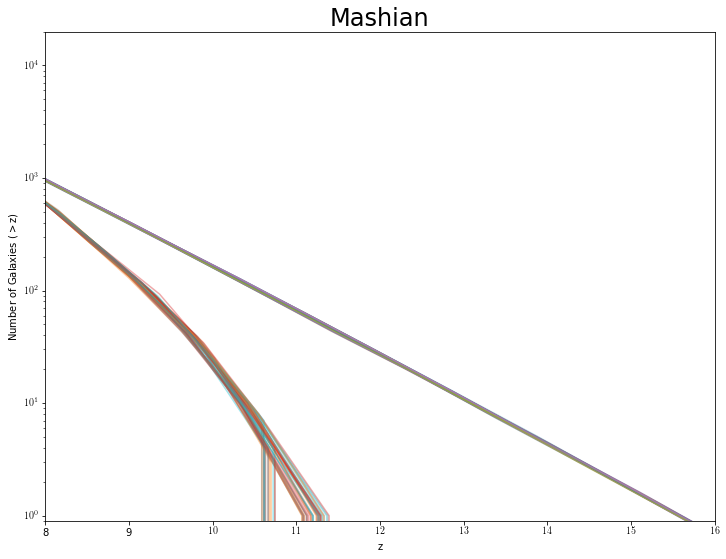

In [9]:
from tqdm import tqdm
N=50
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the idealized survey from Mashian et al. 2015
    mashian = survey(31.5, 200./3600, "cv_mashian.csv")
    mean_mashian, med_mashian, z_vals_mashian = mean_median(mashian, correction=0)
    summed+=med_mashian
    summean+=mean_mashian
    plt.rcParams.update({'font.size': 20})
    plt.rc('font', family='serif')
    plt.rc('text', usetex=True)

    ax.plot(z_vals_mashian, mean_mashian, alpha=0.4, label = "Mean")
    ax.plot(z_vals_mashian, med_mashian, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,16), title='Mashian')
    if save==1:
        plt.savefig("figs/"+file+"/mashian.pdf")
winsound.Beep(400,300)

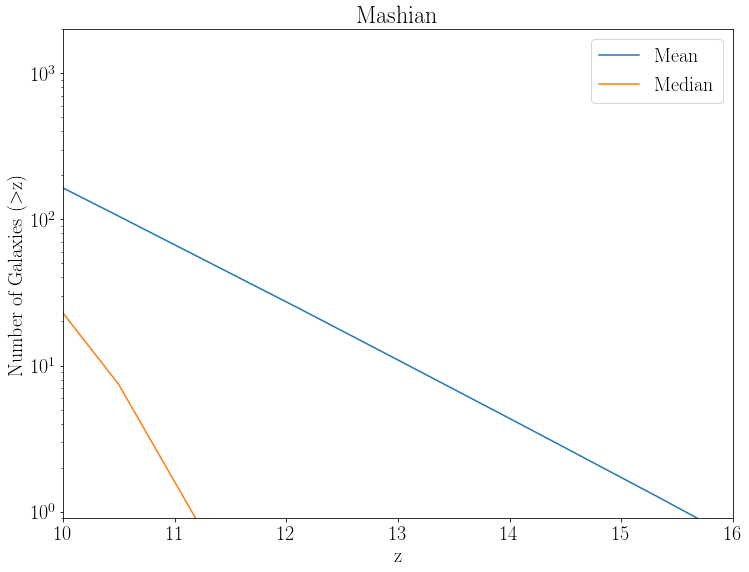

In [10]:
fig, ax =plt.subplots(figsize=(12,9))
plt.rcParams.update({'font.size': 20})
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(10,16), title='Mashian')
if save==1:
    plt.savefig("figs/"+file+"/mashian.pdf")

In [11]:
from scipy.interpolate import interp1d
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
def find_min(f):
    x=8
    while f(x)>1:
        x+=0.001
    print(f(x))
    return x

z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9980568346293079
0.9993362183521991


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


(11.168999999998244, 11.2695, 15.574999999995802)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [21:07<00:00, 25.35s/it]


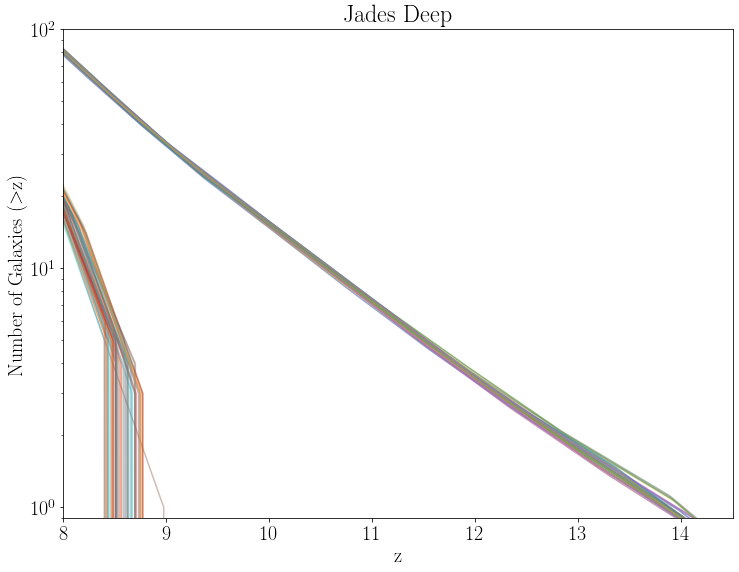

In [12]:
fig, ax = plt.subplots(figsize=(12,9))
meds, means = [],[]
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Deep survey from Williams et al. 2018 (pg. 36)
    deep = survey(30.7, 46./3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4))
    mean_deep, med_deep, z_vals_deep = mean_median(deep)
    summed+=med_deep
    summean+=mean_deep
    meds.append(med_deep)
    means.append(mean_deep)
    ax.plot(z_vals_deep, mean_deep, alpha=0.4, label = "Mean")
    ax.plot(z_vals_deep, med_deep, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14.5), title='Jades Deep')
winsound.Beep(400,300)

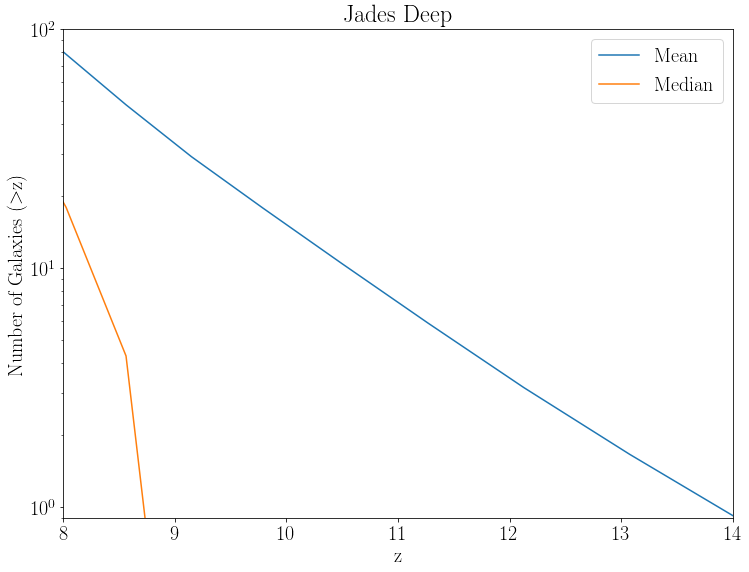

In [13]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14), title='Jades Deep')
if save==1:
    plt.savefig("figs/"+file+"/jadesdeep.pdf")

In [14]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9960112347638762
0.9996963240363459


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(8.895999999999503, 9.149, 13.88199999999674)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [17:39<00:00, 21.19s/it]


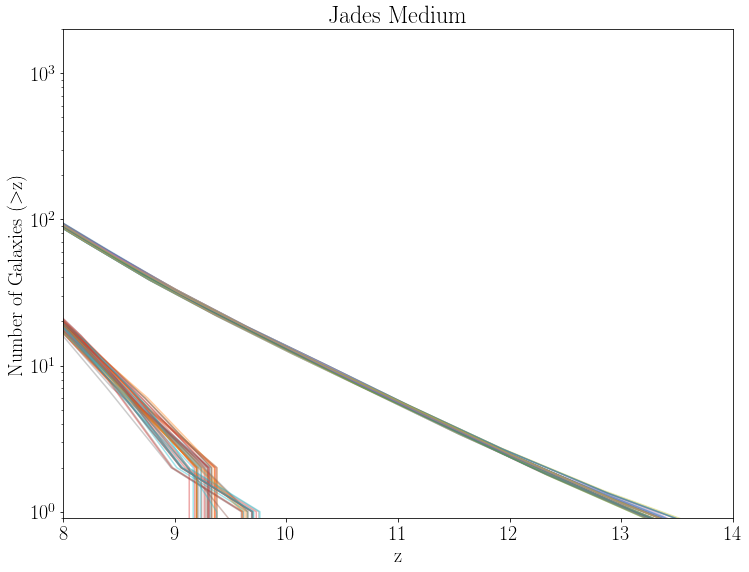

In [15]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design matching the JADES Wide survey from Williams et al. 2018 (pg. 36)

    wide = survey(29.85, 190./3600, "cv_jades_wide.csv", nearest_wavelength(x,14873.4))
    mean_wide, med_wide, z_vals_wide = mean_median(wide)
    summed+=med_wide
    summean+=mean_wide

    ax.plot(z_vals_wide, mean_wide, alpha=0.4, label = "Mean")
    ax.plot(z_vals_wide, med_wide, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e3), xlim=(8,14), title='Jades Medium')
winsound.Beep(400,300)

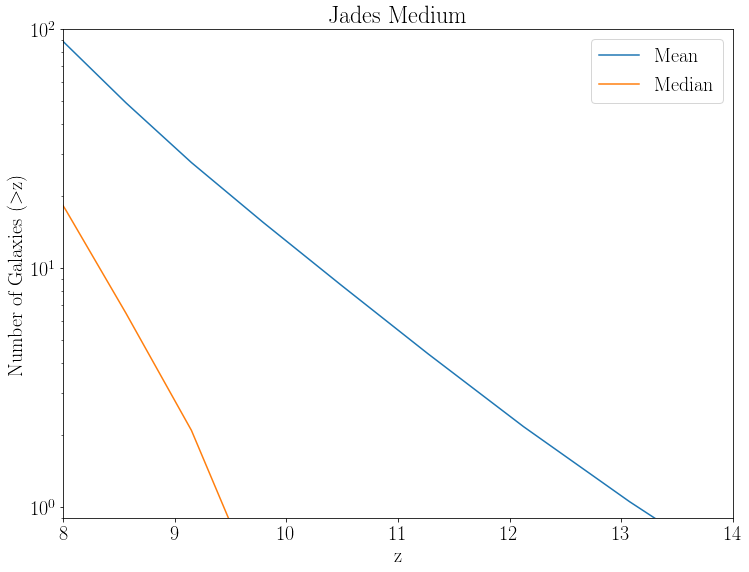

In [16]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14), title='Jades Medium')
if save==1:
    plt.savefig("figs/"+file+"/jadesmedium.pdf")

In [17]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9993936311275032
0.9994886156030195


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(9.476999999999181, 9.7905, 13.152999999997144)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [27:46<00:00, 33.32s/it]


0.9985256487166535
0.9999702309507147


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in add


(10.335999999998705, 10.4945, 15.82999999999566)

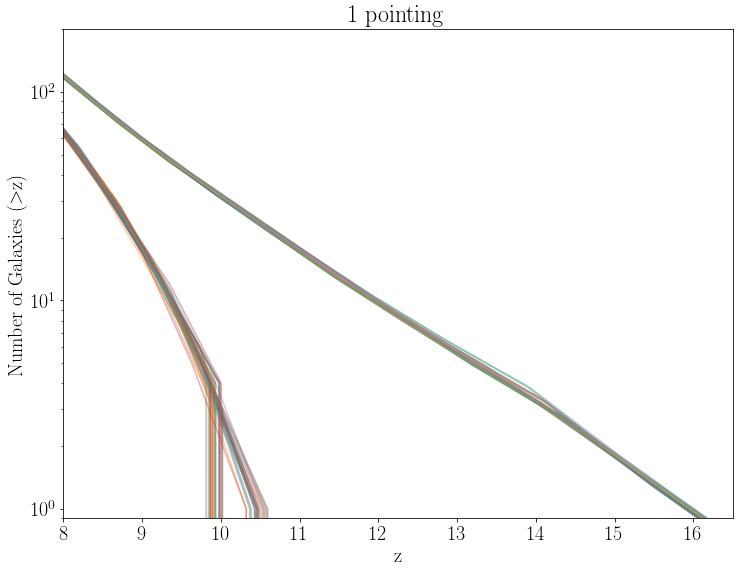

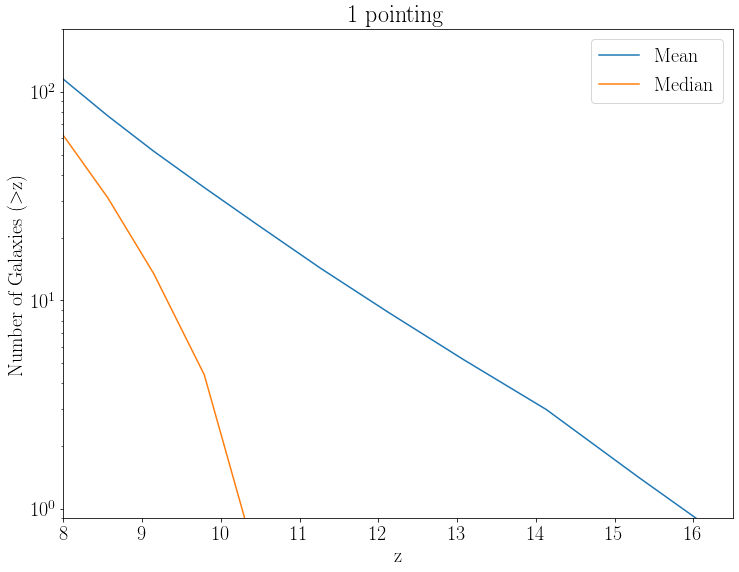

In [18]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(32.2, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,16.5), title='1 pointing')
winsound.Beep(400,300)
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e2), xlim=(8,16.5), title='1 pointing')
if save==1:
    plt.savefig("figs/"+file+"/1.pdf")
    
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [19:57<00:00, 23.96s/it]


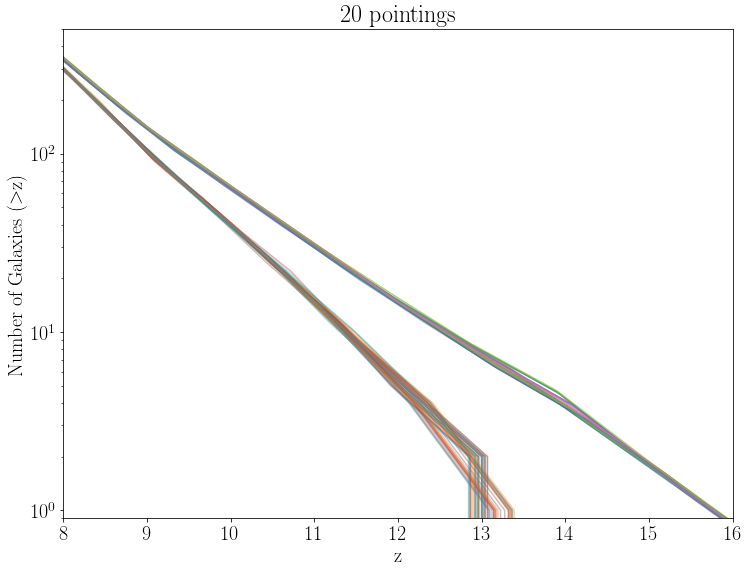

In [19]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 35 parallel pointings of JWST
    # Uses limiting magnitude from JADES Deep, area of one JWST pointing

    parallel_35 = survey(30.7, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 20)
    mean_35, med_35, z_vals_35 = mean_median(parallel_35)
    summed+=med_35
    summean+=mean_35

    ax.plot(z_vals_35, mean_35, alpha=0.4, label = "Mean")
    ax.plot(z_vals_35, med_35, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='20 pointings')
winsound.Beep(400,300)

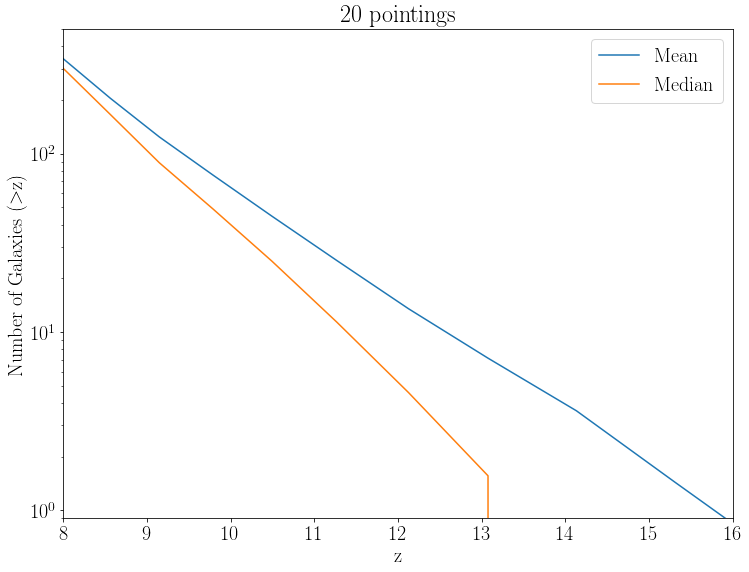

In [20]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='20 pointings')
if save==1:
    plt.savefig("figs/"+file+"/20.pdf")

In [21]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.999386706068996
0.999653617452547


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(13.35999999999703, 13.0755, 15.74099999999571)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [16:46<00:00, 20.14s/it]


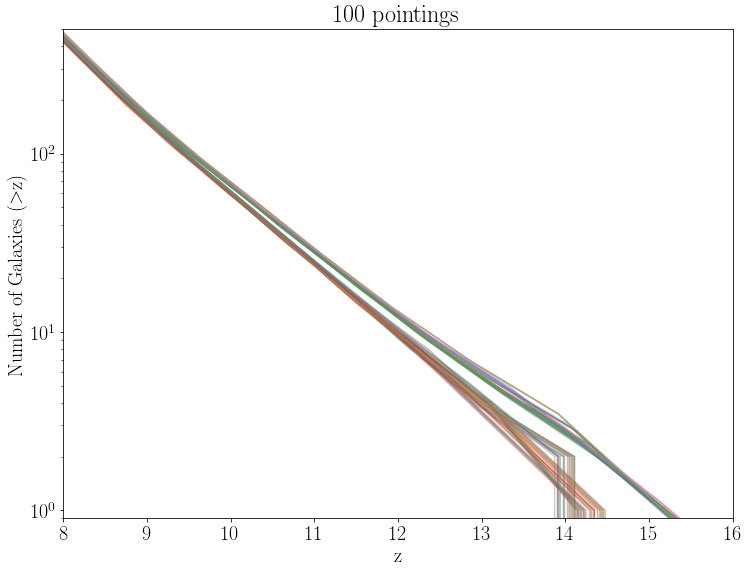

In [22]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 100 parallel pointings of JWST

    parallel_200 = survey(29.85, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 100)
    mean_200, med_200, z_vals_200 = mean_median(parallel_200)
    summed+=med_200
    summean+=mean_200

    ax.plot(z_vals_200, mean_200, alpha=0.4, label = "Mean")
    ax.plot(z_vals_200, med_200, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='100 pointings')
winsound.Beep(400,300)

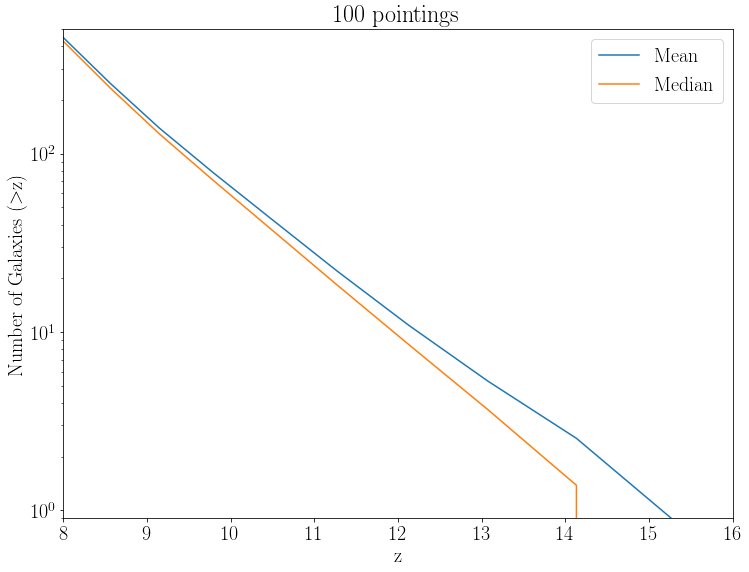

In [23]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,16), title='100 pointings')
if save==1:
    plt.savefig("figs/"+file+"/100.pdf")

In [24]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9988682439676762
0.9998513429810217


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(14.382999999996462, 14.1315, 15.171999999996025)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [14:08<00:00, 16.96s/it]


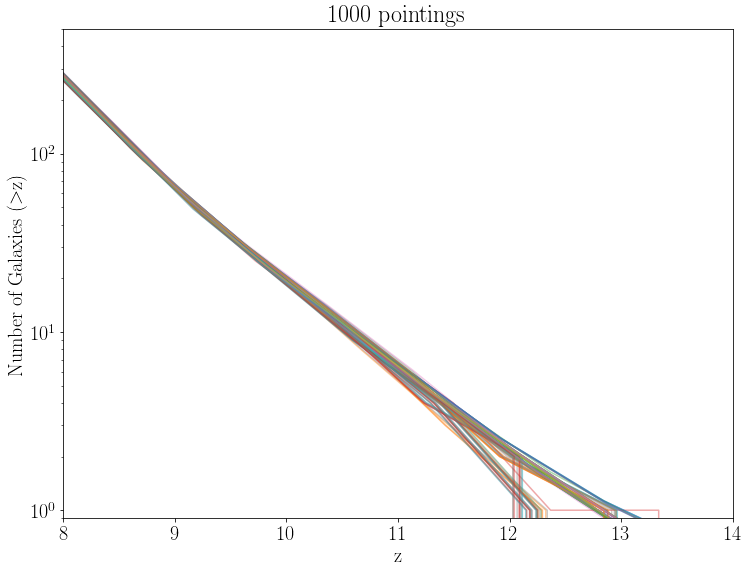

In [25]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design assuming 200 parallel pointings of JWST

    parallel_2000 = survey(28.5, 2*4.84/3600, "cv_one_pointing.csv", nearest_wavelength(x,14873.4), 1000)
    mean_2000, med_2000, z_vals_2000 = mean_median(parallel_2000)
    summed+=med_2000
    summean+=mean_2000

    ax.plot(z_vals_2000, mean_2000, alpha=0.4, label = "Mean")
    ax.plot(z_vals_2000, med_2000, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,14), title='1000 pointings')
winsound.Beep(400,300)

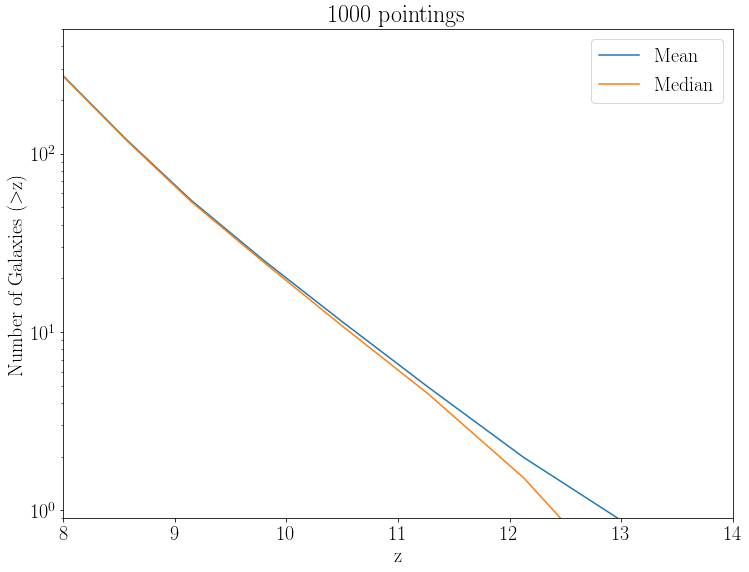

In [26]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")

ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,5e2), xlim=(8,14), title='1000 pointings')
ax.legend()
if save==1:
    plt.savefig("figs/"+file+"/1000.pdf")

In [27]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9985790807150682
0.9996726038040099


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.414999999997553, 13.0755, 12.83599999999732)

In [28]:
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [32:23<00:00, 38.88s/it]


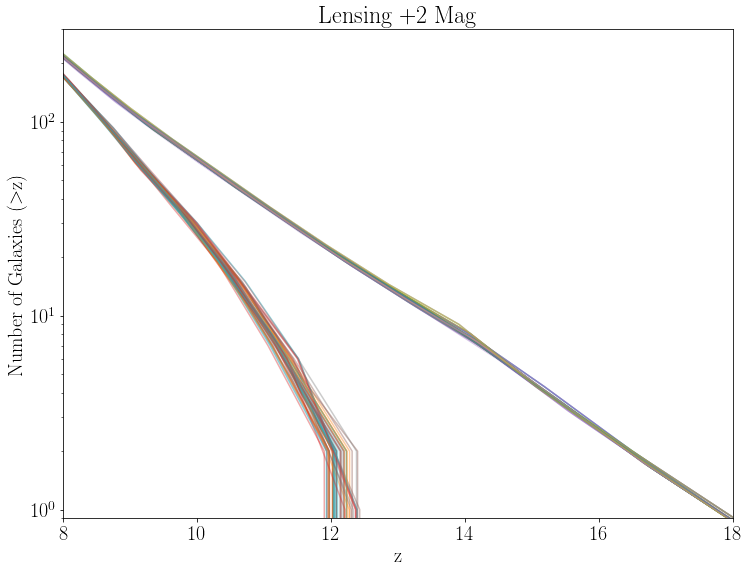

In [29]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
# Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
# Assumes this is over one JWST pointing

    lensing_2 = survey(30.7 + 2, 2*4.84/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,3e2), xlim=(8,18), title='Lensing +2 Mag')
winsound.Beep(400,300)

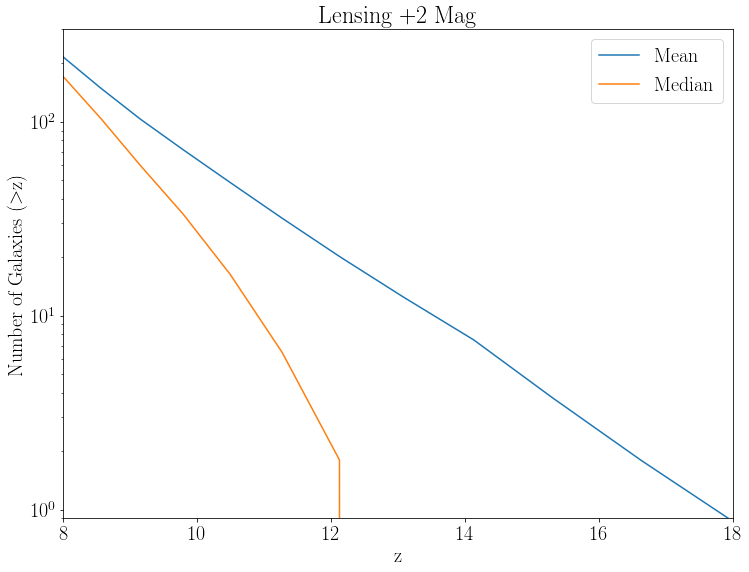

In [30]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,3e2), xlim=(8,18), title='Lensing +2 Mag')
if save==1:
    plt.savefig("figs/"+file+"/lensfull+2.pdf")

In [31]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9990670171094732
0.9998190176184389


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(12.407999999997557, 12.126, 17.73799999999769)

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:00:06<00:00, 72.14s/it]


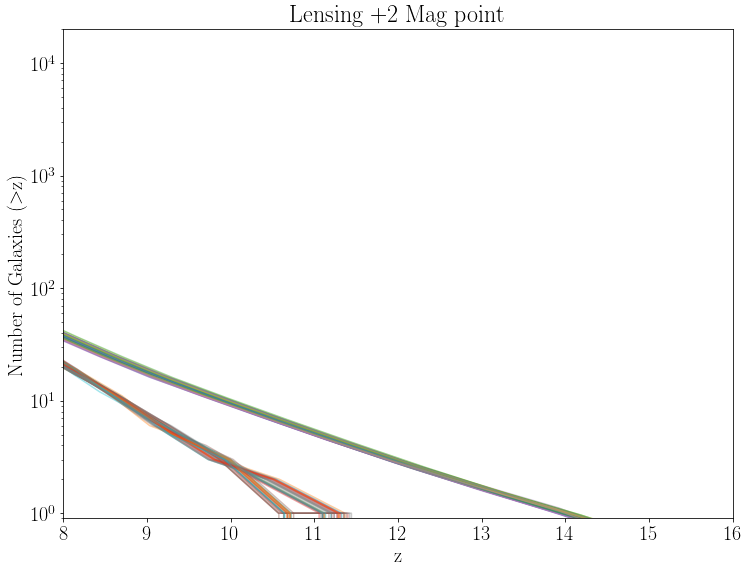

In [37]:
fig, ax = plt.subplots(figsize=(12,9))
summed=np.zeros(len(z_vals))
summean=np.zeros(len(z_vals))
for _ in tqdm(range(N)):   
    # Survey design modeling the effect of lensing by increasing limiting magnitude of JADES Deep survey by 2
    # Assumes this is over one square arcsecond
    lensing_2 = survey(30.7 + 2, 1/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens, med_lens, z_vals_lens = mean_median(lensing_2)
    lensing_rest = survey(30.7, 8.6/3600, "cv_jades_deep.csv", nearest_wavelength(x,14873.4), 1)
    mean_lens1, med_lens1, zvals1  = mean_median(lensing_rest)
    mean_lens+=mean_lens1
    med_lens+=med_lens1
    summed+=med_lens
    summean+=mean_lens

    ax.plot(z_vals_lens, mean_lens, alpha=0.4, label = "Mean")
    ax.plot(z_vals_lens, med_lens, alpha=0.4,label = "Median")

    ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,2e4), xlim=(8,16), title='Lensing +2 Mag point')
winsound.Beep(400,300)

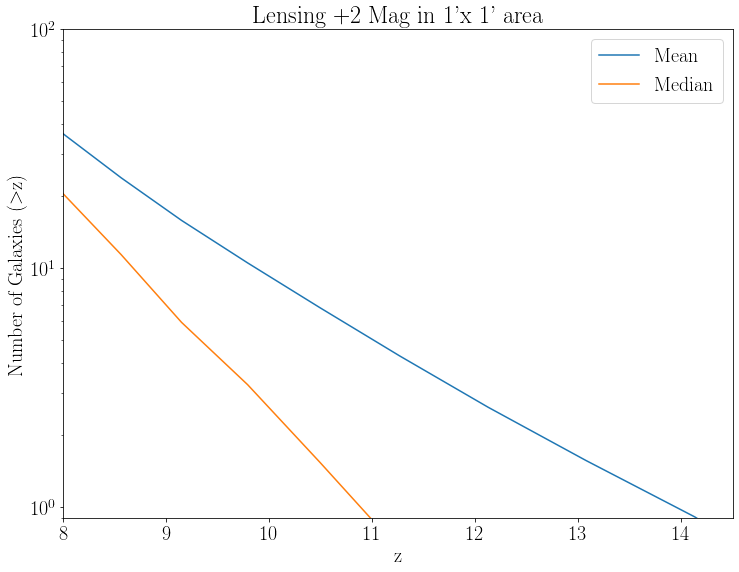

In [38]:
fig, ax =plt.subplots(figsize=(12,9))

ax.plot(z_vals, summean/N,label = "Mean")
ax.plot(z_vals, summed/N,label = "Median")
ax.legend()
ax.set(xlabel="z", ylabel="Number of Galaxies"r" ($>$z)", yscale="log", ylim=(0.9,1e2), xlim=(8,14.5), title="Lensing +2 Mag in 1'x 1' area")
if save==1:
    plt.savefig("figs/"+file+"/lenspoint+2.pdf")

In [39]:
fmed = interp1d(z_vals, summed/N, 'cubic')
fmean = interp1d(z_vals, summean/N, "cubic")
z_med, z_mean = find_min(fmed), find_min(fmean)
z_med, z_vals[73-max(np.argwhere(np.isnan(np.log(summed)+np.inf)).flatten())], z_mean

0.9995959214119831
0.9999698476470187


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in add
  after removing the cwd from sys.path.


(10.897999999998394, 11.2695, 13.958999999996697)